# ワーカ間一致率によるクラウドソーシング結果の評価

## 準備

### Google Colabにインストールされていないライブラリを導入する

In [ ]:
!pip install crowd-kit
!pip install krippendorff

### ライブラリをインポートする

In [1]:
import numpy as np
import pandas as pd
import krippendorff

## クリッペンドルフのαを計算する
講義資料で示した２つの場合について，krippendorffライブラリを用いてαを計算し，手計算の結果と一致しているか見てみましょう

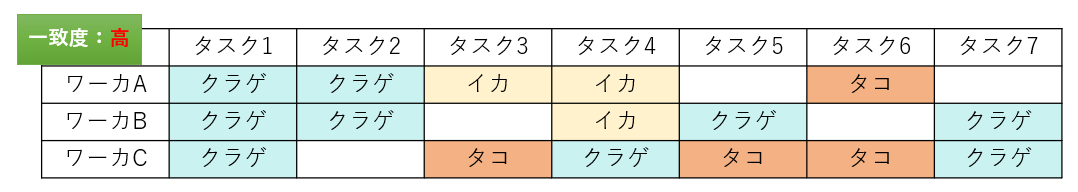

In [11]:
# krippendorffライブラリでは，ワーカが回答しない場合はnp.nanとする
worker_A = ("クラゲ","クラゲ","イカ","イカ",np.nan,"タコ",np.nan)
worker_B = ("クラゲ","クラゲ",np.nan,"イカ","クラゲ",np.nan,"クラゲ")
worker_C = ("クラゲ",np.nan,"タコ","クラゲ","タコ","タコ","クラゲ")

# 回答をまとめる
responses = (worker_A, worker_B, worker_C)

# 計算する
krippendorff.alpha(reliability_data=responses, level_of_measurement="nominal")

0.4

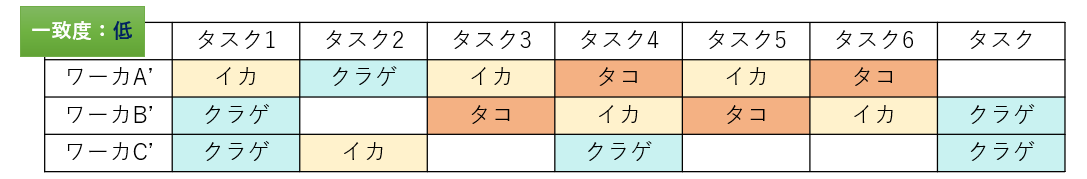

In [12]:
# krippendorffライブラリでは，ワーカが回答しない場合はnp.nanとする
worker_A = ("イカ","クラゲ","イカ","タコ","イカ","タコ",np.nan)
worker_B = ("クラゲ",np.nan,"タコ","イカ","タコ","イカ","クラゲ")
worker_C = ("クラゲ","イカ",np.nan,"クラゲ",np.nan,np.nan,"クラゲ")

# 回答をまとめる
responses = (worker_A, worker_B, worker_C)

# 計算する
krippendorff.alpha(reliability_data=responses, level_of_measurement="nominal")

-0.1607142857142856

## 公開データセットのクリッペンドルフのαを計算してみる
クラウドソーシング企業Toloka社が公開しているデータセット`relevance-2`を用いて，実際のアノテーション結果を対象に実験してみましょう．

In [14]:
from crowdkit.datasets.load_dataset import load_dataset

In [15]:
df, gt = load_dataset('relevance-2')

データセットの中身を見てみましょう．
（`gt`は正解データで，今回は使いません）

In [16]:
df.head()

,worker,task,label
0,w851,t30685,1
1,w6991,t30008,0
2,w2596,t36316,0
3,w5507,t15145,1
4,w2982,t44785,1


データセットは`(ワーカID, タスクID, 回答)`のタプルのリストになっています．

与えられた二つのテキストが，関連している内容`1`かそうでない`0`かを問うタスクです．

In [19]:
df.count()

worker    475536
task      475536
label     475536
dtype: int64

47万件以上もの回答が含まれている巨大なデータセットです．

このデータをkrippendorffライブラリで扱えるように変形します（少し時間がかかります）．

In [25]:
responses =  df.pivot_table(index='worker', columns='task', values='label', fill_value=np.nan)

In [30]:
responses.shape

(7138, 99319)

(ワーカ数,タスク数）の行列に変換されています

計算してみましょう

In [28]:
krippendorff.alpha(reliability_data=responses, level_of_measurement="nominal")

0.2619204046699479

意外に低い値になっています

## データセットにスパムワーカを追加する
このデータセットに悪いふるまいをするワーカを追加してみましょう．

悪いふるまいをするワーカはすべてのタスクにランダムに回答します

このスパムワーカを20人追加します

In [34]:
num_tasks = responses.shape[1] # 総タスク数
num_spam_workers = 20 # スパムワーカ数

In [40]:
spam_workers = np.array([np.random.randint(low=0,high=1+1,size=num_tasks) for _ in range(num_spam_workers)])

In [42]:
spam_workers, spam_workers.shape

(array([[0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 0]]),
 (20, 99319))

In [44]:
responses_with_spam = np.concatenate([responses, spam_workers]) # データセットとスパムワーカ結果を結合

In [45]:
krippendorff.alpha(reliability_data=responses_with_spam, level_of_measurement="nominal")

0.007355578941477092

ランダムなふるまいをするスパムワーカの影響で，クリッペンドルフのαが0に近づいたことがわかります．

## 余裕があればやってみよう
 - スパムワーカの数を増減して，クリッペンドルフのαがどう変化するか観察してみましょう
 - `relevance-5`は同じくテキストの関連度を答えるタスクですが，５段階の順序付き回帰問題になっています．`krippendorff.alpha`を`level_of_measurement="ordinal"`として実行し，クリッペンドルフのαを計算してみましょう（`load_dataset('relevance-5')`でダウンロードできます）
 - 自分でクラス分類に対するクリッペンドルフのαを計算する関数を書いてみましょう
 - クラス分類ではない場合のクリッペンドルフのαがどう計算されるのか，調べてみましょう